# Tema 3: Entrega práctica - Estudio final preprocesado

### Autor: Juan José Méndez Torrero

### Asignatura: Procesamiento y Visualización de Datos

El estudio debe contener:

1. Una introducción explicando de qué son los datos con los que se va a trabajar y la motivación por la que se han elegido. En el curso hemos visto algunas fuentes de datos, quizá más de tipo investigación, pero hay muchísimas más, por ejemplo, pueden usarse datos de alguno de los portales de open data.
2. Una explicación y el código de cómo se ha hecho la carga y/o extracción de los datos
3. Una explicación y el código del análisis preliminar de los datos incluyendo al menos dos de las siguientes cuestiones:
    - Una descripción de las características con sus medidas básicas
    - Comentar las posibles correlaciones entre las características
    - Analizar la distribución de las características
    - Detectar si hay anomalías en los datos
4. El código y la explicación de lo que se ha hecho para crear una versión de los datos con:
    - todas las características continuas transformadas al intervalo [0,1]
    - todas las características categóricas binarizadas con one hot encoding.
    - imputación de los valores perdidos (si los hay) con el método que se estime oportuno.
5. Aplicación de algun/os método/s de selección de características y comentario de los resultados.

# Elección de datos

1. https://www.openml.org/d/1483

#### Importamos las librerías necesarias

In [63]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import mutual_info_score
import pandas as pd
import numpy as np
from scipy.stats import chisquare

import seaborn as sns
import matplotlib.pyplot as plt

#### Descargamos el dataset deseado

In [64]:
data = datasets.fetch_openml('credit-g', as_frame=True)

#### Agrupamos los datos para poder procesarlos

In [65]:
x = pd.DataFrame(data["data"], columns=data["feature_names"])

x["class"] = data["target"]

x.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [66]:
numeric_columns = []
nominal_columns = []
for col in x.columns.values:
    if type(x[col][0]) == str:
        nominal_columns.append(col)
    else:
        numeric_columns.append(col)

print("Las columnas numéricas son: {0}".format(str(numeric_columns)))
print("Las columnas nominales son: {0}".format(str(nominal_columns)))

Las columnas numéricas son: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Las columnas nominales son: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']


In [67]:
x.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


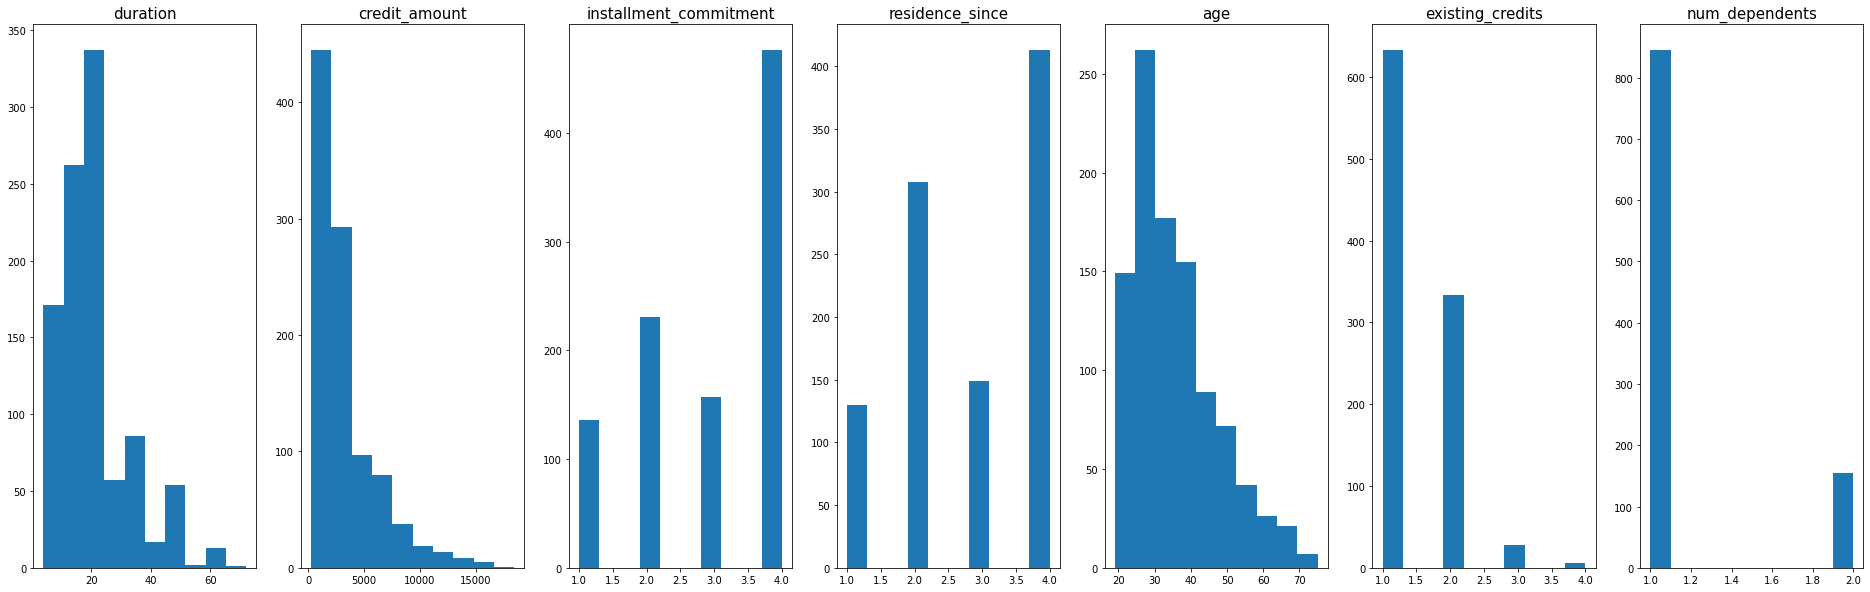

In [68]:
fig = plt.figure(figsize = (100,10))

i=1

for col in numeric_columns:
    ax = fig.add_subplot(1,len(x.columns), i)
    ax.set_title(col, fontsize = 15)
    ax.hist(x[col], bins=10)

    i += 1

#### Correlaciones entre características

<AxesSubplot:>

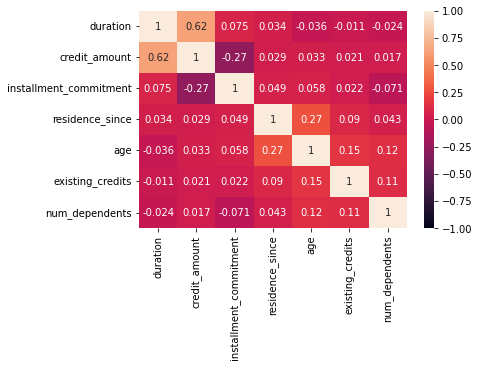

In [69]:
sns.heatmap(x.corr(), vmin=-1, vmax=1, annot=True)

In [70]:
factorized_data = x[nominal_columns].apply(lambda x: pd.factorize(x)[0])+1

pd.DataFrame([chisquare(factorized_data[x].values,f_exp=factorized_data.values.T,axis=1)[0] for x in factorized_data])


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
[0.         0.1107814  0.52003562 0.0173642  0.14024933 0.33214709
 0.98059965 0.12911843 0.8215734  0.53206003 0.43790013 0.40726817
 1.16586307 0.72769231]